## Логистическая регрессия

В основе ее - логистическая фнукция (сигмоида).

Значения сигмоиды лежат в диапазоне от 0 до 1. Если искомая оценка вероятности > 0.5, относим объект к классу 1, если P <= 0.5 - к классу 0

In [1]:
from math import exp
z = 1 + 5*0.3 - 0.3*3
P = 1/(1+exp(-z))
print(round(P, 2))

0.83


Правдоподобие — это оценка того, насколько вероятно получить истинное значение целевой переменной y при данных x и параметрах w.

Цель метода — найти такие параметры w, в которых наблюдается МАКСИМУМ функции правдоподобия.

К сожалению, функция likelihood не имеет интерпретации.

Если поставим минус перед формулой функции, мы получим функцию потерь L(w), которая носит название «функция логистических потерь», или logloss. Также часто можно встретить название КРОСС-ЭНТРОПИЯ, или cross-entropy loss. Мы должны найти такие параметры разделяющей плоскости w, при которых наблюдается МИНИМУМ logloss.

Во избежание переобучения модели в функцию потерь логистической регрессии традиционно добавляется регуляризация. Значение коэффициента С — коэффициент, обратный коэффициенту регуляризации. Чем больше С, тем меньше «сила» регуляризации.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации


import warnings # для игнорирования предупреждений
#Игнорируем предупреждения
warnings.filterwarnings('ignore')

In [16]:
diabetes = pd.read_csv('/Users/olgazdanova/Downloads/diabetes_cleaned.csv')
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,98.0,58.0,33.0,34.0,0.430,43,0
1,2,112.0,75.0,32.0,35.7,0.148,21,0
2,2,108.0,64.0,29.0,30.8,0.158,21,0
3,8,107.0,80.0,29.0,24.6,0.856,34,0
4,7,136.0,90.0,29.0,29.9,0.210,50,0


In [3]:
diabetes.shape

(757, 8)

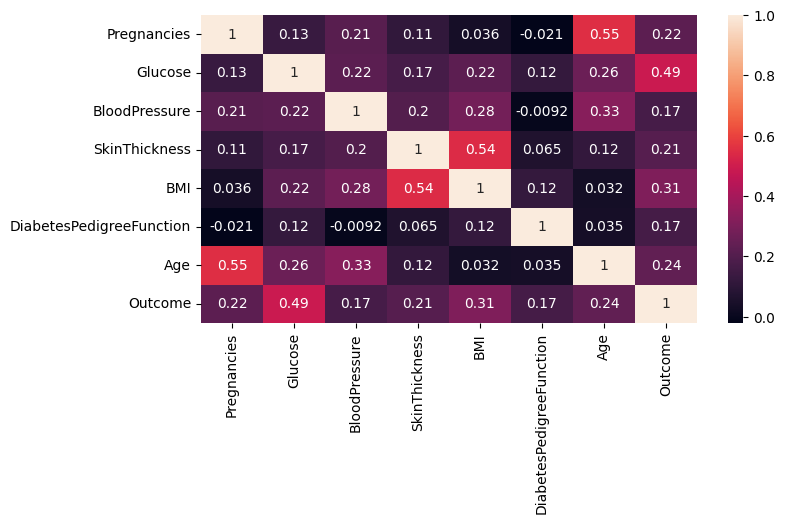

In [4]:
fig, ax = plt.subplots(figsize = (8, 4))
sns.heatmap(diabetes.corr(), annot=True);

Возьмем признаки наиболее скоррелированные с outcome (target) и построим диаграмму рассеяния

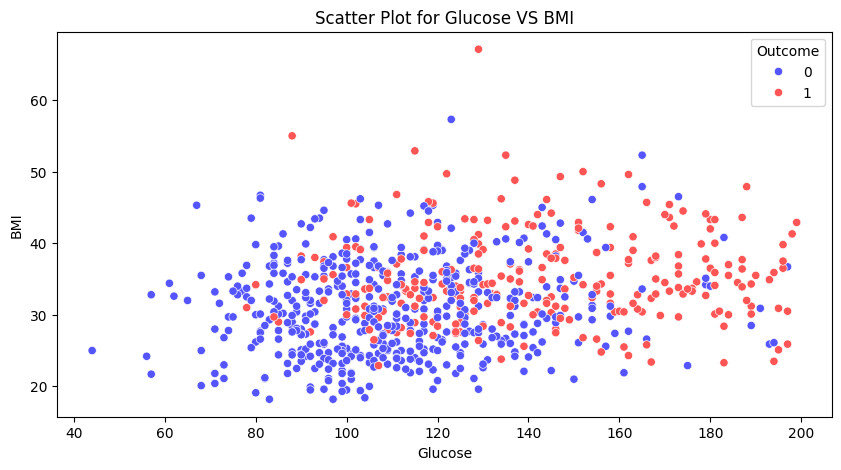

In [17]:
fig, ax = plt.subplots(figsize=(10,5)) # фигура + координатная плоскость
# строим диаграмму рассеяния
sns.scatterplot(
    data = diabetes,
    x='Glucose', # ось абсцисс
    y='BMI', # ось ординат
    hue='Outcome', # признак для группировки
    palette='seismic',
    ax=ax
);
ax.set_title('Scatter Plot for Glucose VS BMI');

Видно, что классы довольно сильно перемешаны, но красные точки, соответствующие пациентам с диабетом, преимущественно сгруппированы в правой части системы координат.

Попробуем построить разделяющую плоскость с помощью логистической регрессии.

In [18]:
X = diabetes[['Glucose', 'BMI']]
y = diabetes['Outcome']

In [7]:
from sklearn.linear_model import LogisticRegression
log_reg_2d = LogisticRegression(random_state=42) # остальные параметры оставляем по умолчанию
log_reg_2d.fit(X, y)
print('w0: {}'.format(log_reg_2d.intercept_))
print('w1, w2: {}'.format(log_reg_2d.coef_))

w0: [-8.24901758]
w1, w2: [[0.03779291 0.08757414]]


In [8]:
# появилось новое наблюдение
x_new = pd.DataFrame({'Glucose': [180], 'BMI': [51]})
# делаем предсказание вероятностей:
y_new_proba_predict = log_reg_2d.predict_proba(x_new)
print('Predicted probabilities: {}'.format(np.round(y_new_proba_predict, 2)))

Predicted probabilities: [[0.05 0.95]]


Метод возвращает сразу две вероятности: первая соответствует вероятности принадлежности к классу 0 (диабета нет), а вторая — вероятности принадлежности к классу 1 (диабет есть). Заметим, что в сумме две вероятности дают 1, что вполне логично, так как события взаимоисключающие.

In [9]:
# можно сделать предсказание класса
y_new_predict = log_reg_2d.predict(x_new)
print('Predicted class: {}'.format(y_new_predict))

Predicted class: [1]


По умолчанию метод predict() относит объект к классу 1, если вероятность принадлежности к классу 1 > 0.5, и к классу 0, если эта вероятность < 0.5.

In [28]:
#Функция для визуализации модели
def plot_probabilities_2d(X, y, model):
    #Генерируем координатную сетку из всех возможных значений для признаков
    #Glucose изменяется от x1_min = 44 до x2_max = 199, 
    #BMI — от x2_min = 18.2 до x2_max = 67.1
    #Результат работы функции — два массива xx1 и xx2, которые образуют координатную сетку
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    #Вытягиваем каждый из массивов в вектор-столбец — reshape(-1, 1)
    #Объединяем два столбца в таблицу с помощью hstack
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    #Предсказываем вероятность для всех точек на координатной сетке
    #Нам нужна только вероятность класса 1
    probs = model.predict_proba(X_net)[:, 1]
    #Переводим столбец из вероятностей в размер координатной сетки
    probs = probs.reshape(xx1.shape)
    #Создаём фигуру и координатную плоскость
    fig, ax = plt.subplots(figsize = (10, 5))
    #Рисуем тепловую карту вероятностей
    contour = ax.contourf(xx1, xx2, probs, 100, cmap='bwr')
    #Рисуем разделяющую плоскость — линию, где вероятность равна 0.5
    bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    #Добавляем цветовую панель 
    colorbar = fig.colorbar(contour)
    #Накладываем поверх тепловой карты диаграмму рассеяния
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette='seismic', ax=ax)
    #Даём графику название
    ax.set_title('Scatter Plot with Decision Boundary');
    #Смещаем легенду в верхний левый угол вне графика
    ax.legend(bbox_to_anchor=(-0.05, 1))

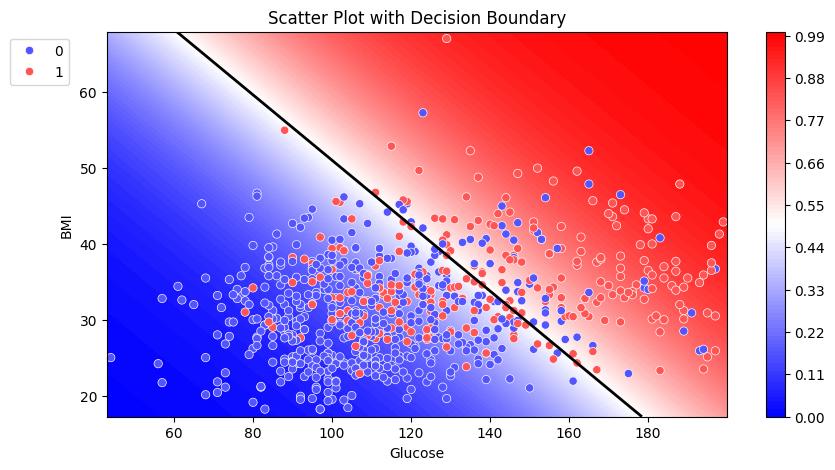

In [11]:
plot_probabilities_2d(X, y, log_reg_2d)

Из графика видно, что довольно много синих точек попали в красную зону и наоборот. Видимо, информации о двух факторах всё же маловато для того, чтобы хорошо провести классификацию.

In [12]:
# используем для построения модели всю информацию

X = diabetes.drop('Outcome', axis=1)
y = diabetes['Outcome']

In [13]:
log_reg_full = LogisticRegression(random_state=42)
log_reg_full.fit(X, y)
y_pred = log_reg_full.predict(X)

In [14]:
# добавим предсказание в таблицу наблюдений для наглядности
X_temp = X.copy()
X_temp['Prediction'] = y_pred
X_temp.tail()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Prediction
752,5,139.0,64.0,35.0,28.6,0.411,26,0
753,1,96.0,122.0,29.0,22.4,0.207,27,0
754,10,101.0,86.0,37.0,45.6,1.136,38,1
755,0,141.0,72.0,29.0,42.4,0.205,29,1
756,0,125.0,96.0,29.0,22.5,0.262,21,0


In [15]:
task = pd.read_csv('/Users/olgazdanova/Downloads/task_data.csv')
task

,SNo,X_1,X_2,y
0,0,-0.869144,0.389310,0.0
1,1,-0.993467,-0.610591,0.0
2,2,-0.834064,0.239236,0.0
3,3,-0.136471,0.632003,1.0
4,4,0.403887,0.310784,1.0
...,...,...,...,...
95,95,0.531635,-0.479185,1.0
96,96,-0.650192,0.655303,1.0
97,97,0.985299,0.118333,1.0
98,98,-0.275289,0.005730,1.0


In [16]:
X = task[['X_1', 'X_2']]
y = task['y']

In [17]:
l_r = LogisticRegression(solver='sag', random_state=42)
l_r.fit(X, y)
y_pred = l_r.predict(X)

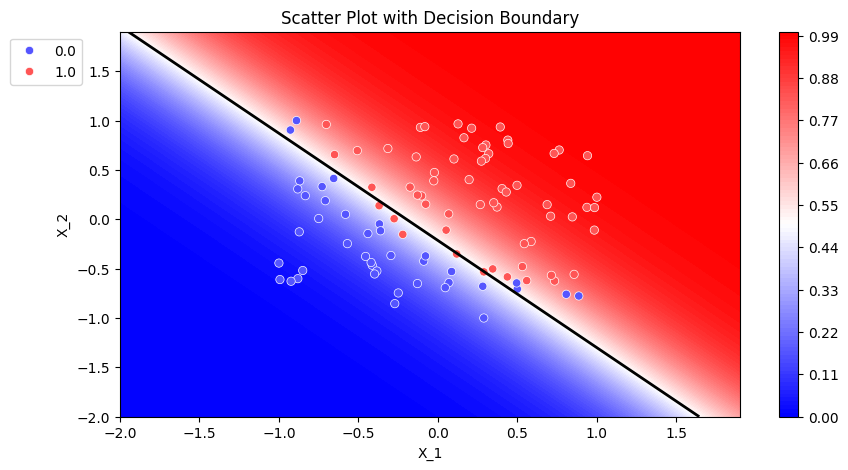

In [18]:
plot_probabilities_2d(X, y, l_r)

## Метрики классификации

1. Матрица ошибок (confusion matrix) - используется для расчета других метрик.

2. Accuracy (достоверность/аккуратность) - доля правильных ответов (TP + TN) среди всех данных ответов (TP+TN+FP+FN). Результативна только на сбалансированных данных!!!

3. Precision(точность) - доля объектов, которые ДЕЙСТВИТЕЛЬНО являются положительными, среди всех, что модель определила как TRUE (TP/(TP+FP))

4. Recall(полнота) - доля объектов, названных положительными, по отношению ко всем объектам положительного класса (TP/(TP+FN))

Обращаем внимание, что на практике часто бывает так, что увеличение одной из метрик (recall, precision) может привести к уменьшению другой.

5. F1-мера - взвешенное среднее между precision и recall (2 * (precision*recall/(precision+recall))). Метрика равна своему максимуму (1), если и precision, и recall равны 1 (то есть когда отсутствуют как ложноположительные, так и ложноотрицательные срабатывания). Но если хотя бы одна из метрик будет близка к 0, то и  будет близка к 0. 

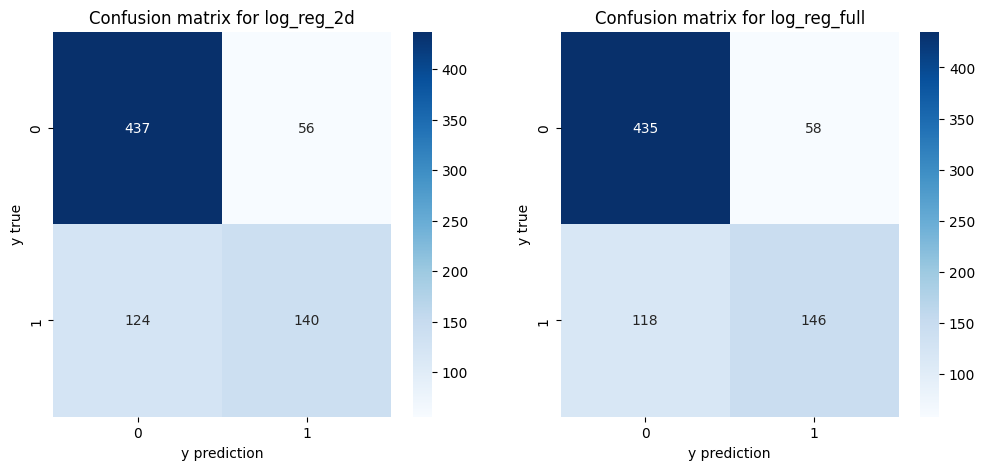

In [20]:
from sklearn import metrics

y_pred1 = log_reg_2d.predict(diabetes[['Glucose', 'BMI']])
y_pred2 = log_reg_full.predict(diabetes.drop('Outcome', axis=1))
y = diabetes['Outcome']

confusion_matrix1 = metrics.confusion_matrix(y, y_pred1)
confusion_matrix2 = metrics.confusion_matrix(y, y_pred2)
#Визуализируем матрицы ошибок
fig, axes = plt.subplots(1, 2, figsize=(12, 5)) #фигура + 2 координатные плоскости
#Строим тепловую карту для первой матрицы ошибок
sns.heatmap(confusion_matrix1, annot=True, fmt='', ax=axes[0], cmap='Blues')
#Добавляем название графику и подписи осей абсцисс и ординат
axes[0].set_title('Confusion matrix for log_reg_2d')
axes[0].set_xlabel('y prediction')
axes[0].set_ylabel('y true')#Строим тепловую карту для второй матрицы ошибок
sns.heatmap(confusion_matrix2, annot=True, fmt='', ax=axes[1], cmap='Blues')
#Добавляем название графику и подписи осей абсцисс и ординат
axes[1].set_title('Confusion matrix for log_reg_full')
axes[1].set_xlabel('y prediction')
axes[1].set_ylabel('y true');

In [24]:
# рассчитываем метрики для первой модели
# метрики рассчитываются для класса 1
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y, y_pred1)))
print('Precision: {:.2f}'.format(metrics.precision_score(y, y_pred1)))
print('Recall: {:.2f}'.format(metrics.recall_score(y, y_pred1)))
print('F1-score: {:.2f}'.format(metrics.f1_score(y, y_pred1)))

Accuracy: 0.76
Precision: 0.71
Recall: 0.53
F1-score: 0.61


In [25]:
# рассчитываем метрики для второй модели
# метрики рассчитываются для класса 1
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y, y_pred2)))
print('Precision: {:.2f}'.format(metrics.precision_score(y, y_pred2)))
print('Recall: {:.2f}'.format(metrics.recall_score(y, y_pred2)))
print('F1-score: {:.2f}'.format(metrics.f1_score(y, y_pred2)))

Accuracy: 0.77
Precision: 0.72
Recall: 0.55
F1-score: 0.62


Видно, что хоть и с небольшим отрывом, но вторая модель, обученная по всем признакам, превосходит первую модель по всем метрикам.

Для облегчения расчёта метрик можно использовать функцию classification_report() из модуля metrics. Она возвращает отчёт обо всех метриках классификации.

In [23]:
print(metrics.classification_report(y, y_pred2))

              precision    recall  f1-score   support

           0       0.79      0.88      0.83       493
           1       0.72      0.55      0.62       264

    accuracy                           0.77       757
   macro avg       0.75      0.72      0.73       757
weighted avg       0.76      0.77      0.76       757



Столбец support — это количество объектов каждого из классов.

Строка macro avg — это среднее значение метрики между классами 1 и 0. Например, значение в строке macro avg и столбце recall = (0.88 + 0.56)/2=0.72.

Строка weighted avg — это средневзвешенное значение метрики между классами 1 и 0. Вес каждого класса определяется на основе доли объекта i-ого класса в выборке.

In [26]:
#Считаем вероятности наличия диабета для каждого из пациентов
#Нас интересует только вероятность класса (второй столбец)
y_proba_pred = log_reg_full.predict_proba(diabetes.drop('Outcome', axis=1))[:, 1]
#Для удобства завернём numpy-массив в Pandas Series
y_proba_pred = pd.Series(y_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #Пациентов, для которых вероятность наличия диабета > threshold, относим к классу 1
    #В противном случае — к классу 0
    y_pred = y_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y, y_pred))
    precision_scores.append(metrics.precision_score(y, y_pred))
    f1_scores.append(metrics.f1_score(y, y_pred))

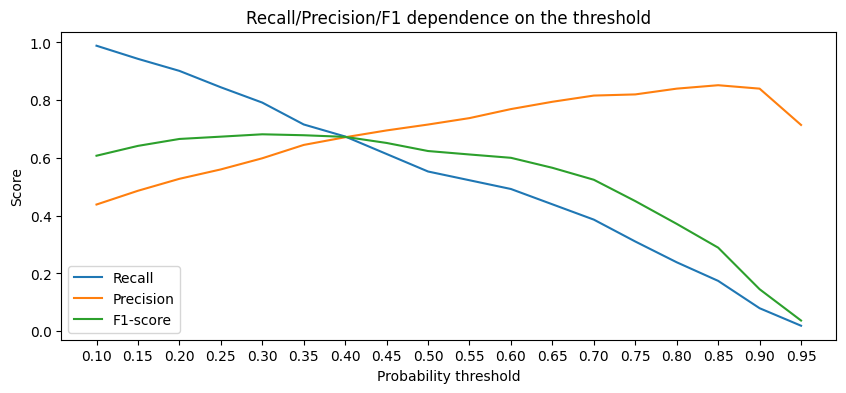

In [27]:
#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')
#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
 
#Даём графику название и подписываем оси
ax.set_title('Recall/Precision/F1 dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси x
ax.set_xticks(thresholds) 
#Отображаем легенду
ax.legend();

С увеличением вероятностного порога повышается precision и падает recall. Очевидно, что с увеличением порога вероятности мы начинаем классифицировать как диабетиков только тех пациентов, в диагнозе которых мы хорошо уверены, то есть мы повышаем точность (precision), но при этом мы отсекаем пациентов, которые больны, но модель выдаёт низкую вероятность болезни, то есть мы уменьшаем охват (recall).

При этом значение F1-меры сначала немного повышается, а затем неуклонно падает.

Интересной является точка threshold=0.4, где происходит пересечение всех трёх графиков. Это точка равенства precision и recall и, как следует из формулы, равенства F1-меры.

Однако максимум F1-меры достигается в другой точке — threshold=0.35. При этом значения recall и precision в этой точке различны: recall выше, а вот precision ниже.

Перед нами стоит выбор, что для нас все таки важнее: precision, recall или их равенство. Давайте сделаем выбор в пользу равенства precision и recall, оно достигается при threshold=0.4.

Мы делаем предсказание вероятности наличия диабета для всех пациентов, а затем вручную определяем всех пациентов, у которых эта вероятность > 0.4, в класс 1, а остальных — в класс 0.

In [28]:
#Задаём оптимальный порог вероятностей
threshold_opt = 0.4
#Пациентов, для которых вероятность наличия диабета > 0.4, относим к классу 1
#В противном случае — к классу 0
y_pred_opt = y_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(metrics.classification_report(y, y_pred_opt))

              precision    recall  f1-score   support

           0       0.83      0.82      0.82       493
           1       0.67      0.67      0.67       264

    accuracy                           0.77       757
   macro avg       0.75      0.75      0.75       757
weighted avg       0.77      0.77      0.77       757



! Стоит отметить, что в DS-сообществе распространена практика подбора оптимального порога, так как он зависит от конкретных задач и значение 0.5 далеко не всегда является истинным.

Подводя итоги по теме логистической регрессии, можно сказать, что единственный ее минус это - Алгоритм работает хорошо, только когда классы линейно разделимы, что в реальных задачах бывает очень редко. Поэтому обычно данная модель используется в качестве baseline.

In [31]:
y_true = [0,0,1,1,1,1,0,1]
y_pred = [0,1,0,0,1,1,0,1]
print('F1-score: {:.2f}'.format(metrics.f1_score(y_true, y_pred)))

F1-score: 0.67


## Мультиклассовая классификация

Если классов больше чем 2 используется подход "один-против-всех". Идея этого подхода очень простая. Если у нас есть k различных классов (k>2), давайте обучим k классификаторов, каждый из которых будет предсказывать вероятности принадлежности каждого объекта к определённому классу.

In [4]:
penguins_data = pd.read_csv('/Users/olgazdanova/Downloads/penguins.csv')
penguins_data.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


Целевой признак - species

In [5]:
penguins_data.isnull().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

Логистическая регрессия — модель, которая не умеет работать с пропусками. Чтобы не получить ошибку, необходимо произвести предварительную предобработку.

In [7]:
# удалим пропуски
penguins_data = penguins_data.dropna()

In [8]:
X = penguins_data.drop('species', axis=1)
y = penguins_data['species']
X.head()

,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
4,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
5,Torgersen,39.3,20.6,190.0,3650.0,MALE


Данные содержат строковые категориальные столбцы — island и sex. Логистическая регрессия не умеет работать со строковыми значениями. Необходимо произвести кодирование категориальных признаков. 

!! Кодировать целевую переменную y не нужно, даже если она представлена в виде строковых значений. Это не влияет на работу модели.

In [9]:
# проведем "горячее" кодирование
X_dummies = pd.get_dummies(X)
X_dummies.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,island_Biscoe,island_Dream,island_Torgersen,sex_FEMALE,sex_MALE
0,39.1,18.7,181.0,3750.0,False,False,True,False,True
1,39.5,17.4,186.0,3800.0,False,False,True,True,False
2,40.3,18.0,195.0,3250.0,False,False,True,True,False
4,36.7,19.3,193.0,3450.0,False,False,True,True,False
5,39.3,20.6,190.0,3650.0,False,False,True,False,True


In [10]:
from sklearn.linear_model import LogisticRegression
l_r = LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42) # выставляем мультиклассовую классификацию
l_r.fit(X_dummies, y)
y_pred_proba = np.round(l_r.predict_proba(X_dummies), 2) # делаем предсказание вероятностей
y_pred = l_r.predict(X_dummies) # делаем предсказание класса

In [13]:
# создадим таблицу из вероятностей для каждого класса и финального предсказания (для наглядности)
y_pred_proba_df = pd.DataFrame(
    y_pred_proba, 
    columns=['Adelie', 'Chinstrap', 'Gentoo']
)

y_pred_df = pd.DataFrame(
    y_pred,
    columns = ['Predicted Class']
)

y_df = pd.concat([y_pred_proba_df, y_pred_df], axis=1)
y_df.sample(5)

,Adelie,Chinstrap,Gentoo,Predicted Class
205,0.07,0.93,0.0,Chinstrap
260,0.00,0.00,1.0,Gentoo
177,0.00,1.00,0.0,Chinstrap
272,0.00,0.00,1.0,Gentoo
40,1.00,0.00,0.0,Adelie


Из таблицы можно проследить, как происходит предсказание класса пингвина на основе полученных вероятностей. Видно, что выбирается класс, вероятность принадлежности к которому максимальна.

In [15]:
# посмотрим отчет о метриках
from sklearn import metrics
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00       146
   Chinstrap       1.00      1.00      1.00        68
      Gentoo       1.00      1.00      1.00       119

    accuracy                           1.00       333
   macro avg       1.00      1.00      1.00       333
weighted avg       1.00      1.00      1.00       333



Из отчёта видно, что наша модель идеально решила задачу классификации (все метрики равны 1), то есть классы оказались линейно разделимыми.

## Деревья решений

Формально структура дерева решений — это связный ациклический граф. Что это значит?

Граф — это абстрактная топологическая модель, которая состоит из вершин и соединяющих их рёбер.

Связный граф — это граф, в котором между любой парой существует направленная связь.

Ациклический граф — это граф, в котором отсутствуют циклы, то есть в графе не существует такого пути, по которому можно вернуться в начальную вершину.

В дереве решений можно выделить три типа вершин: корневая (root node), внутренние (intermediate nodes) и листья (leafs).

Максимально возможная длина от корня до самых дальних листьев (не включая корневую) называется максимальной глубиной дерева (max depth).

Логический критерий, который находится в каждой вершине, называется ПРЕДИКАТОМ, или решающим правилом.

Если результат предиката равен 1, то мы переходим по левой ветви дерева к следующему узлу, в противном случае — по правой ветви дерева к следующему узлу.

Какие критерии информативности используются в деревьях решений? - Энтропия Шеннона и Критерий Джини

In [21]:
from sklearn import tree

dt_clf_2d = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42) # в качестве критерия информативности указали энтропию (можно еще gini)
dt_clf_2d.fit(X, y) # Х - матрица наблюдений по признакам Glucose и BMI

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)

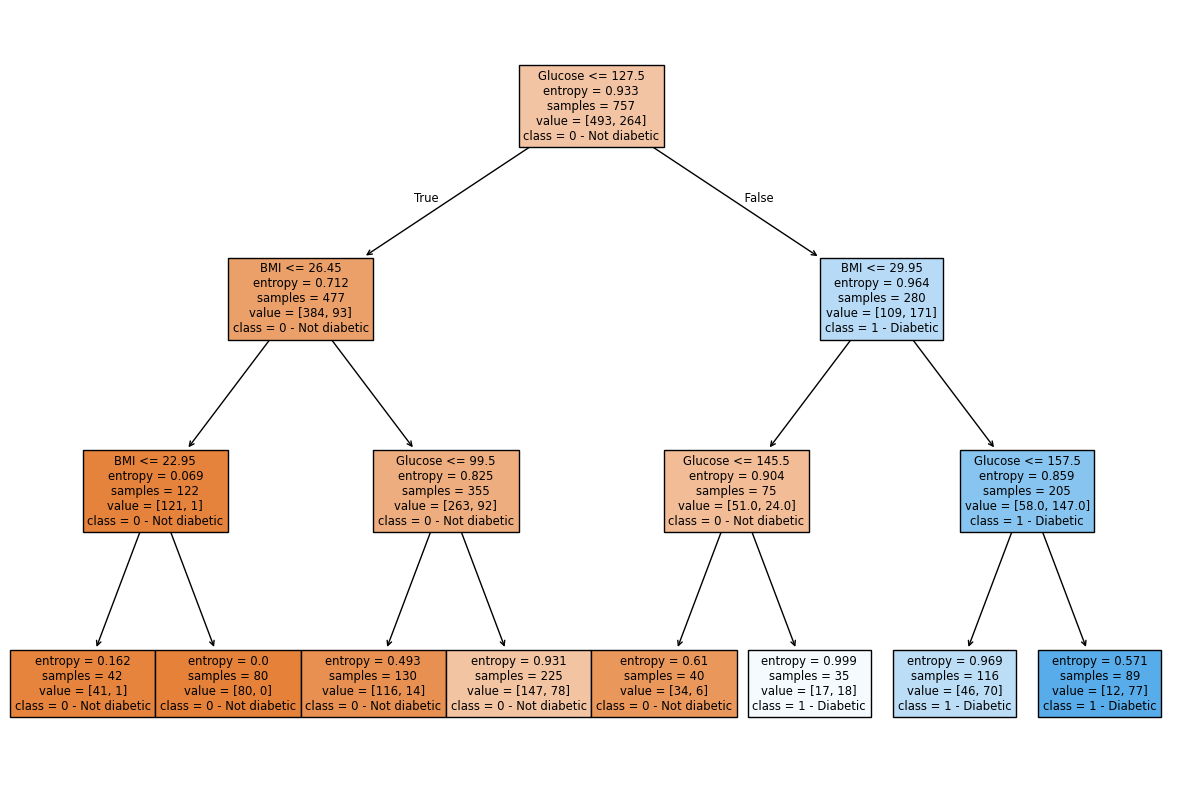

In [22]:
fig = plt.figure(figsize=(15, 10))
tree.plot_tree(
    dt_clf_2d, # объект обученного дерева
    feature_names=X.columns, # наименования факторов
    class_names=['0 - Not diabetic', '1 - Diabetic'], # имена классов
    filled=True # расцветка графов
);


In [23]:
# сделаем предсказание по новым данным
x_new= [[180, 51]]
y_new_predict = dt_clf_2d.predict(x_new)
print('Predicted Class: {}'.format(y_new_predict)) # 1 значит наличие диабета

Predicted Class: [1]


In [27]:
# а также предсказание по вероятности
y_new_proba_predict = dt_clf_2d.predict_proba(x_new)
print('Predicted Probabilities: {}'.format(np.round(y_new_proba_predict, 3)))

Predicted Probabilities: [[0.135 0.865]]


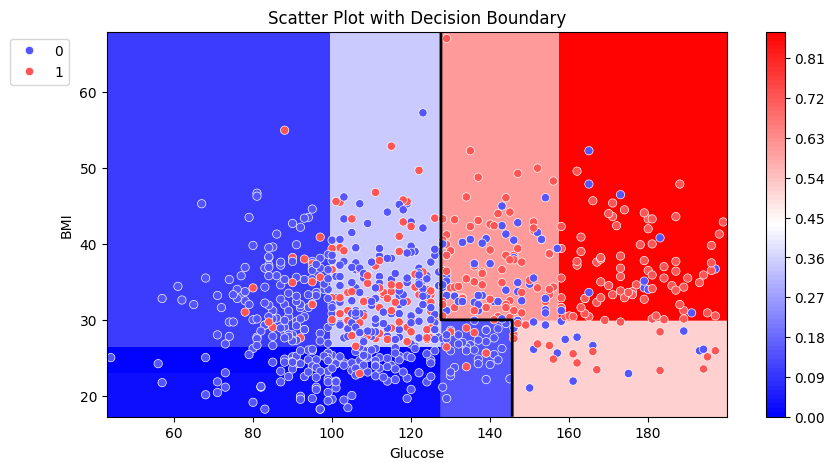

In [29]:
plot_probabilities_2d(X, y, dt_clf_2d)

In [30]:
y_pred = dt_clf_2d.predict(X)
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       493
           1       0.69      0.62      0.65       264

    accuracy                           0.77       757
   macro avg       0.75      0.74      0.74       757
weighted avg       0.77      0.77      0.77       757



In [31]:
# обучим модель без ограничения по глубине
dt_clf_bad = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)
dt_clf_bad.fit(X, y)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [32]:
y_pred_bad = dt_clf_bad.predict(X)
print(metrics.classification_report(y, y_pred_bad))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       493
           1       1.00      0.97      0.98       264

    accuracy                           0.99       757
   macro avg       0.99      0.98      0.99       757
weighted avg       0.99      0.99      0.99       757



Судя по метрикам, теперь все просто замечательно, мы практически идеально решаем задачу предсказания наличия диабета. Но здесь явно что-то не так. Визуализируем граф.

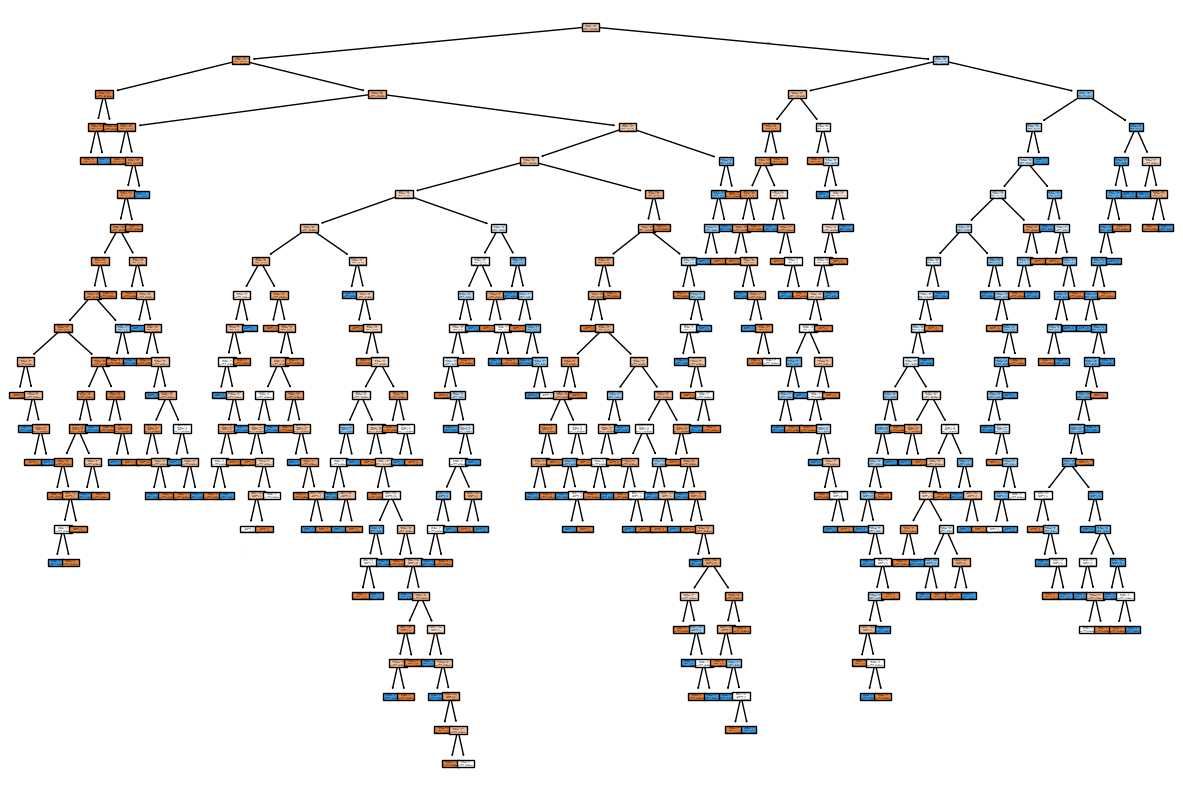

In [33]:
#Создаём фигуру для визуализации графа
fig = plt.figure(figsize=(15, 10))
#Строим граф 
tree_graph = tree.plot_tree(
    dt_clf_bad, #объект обученного дерева
    feature_names=X.columns, #наименования факторов
    class_names=["0 - Not diabetic", "1 - Diabetic"], #имена классов
    filled=True, #расцветка графа
);

In [34]:
# чтобы узнать глубину получившегося дерева
dt_clf_bad.get_depth()

22

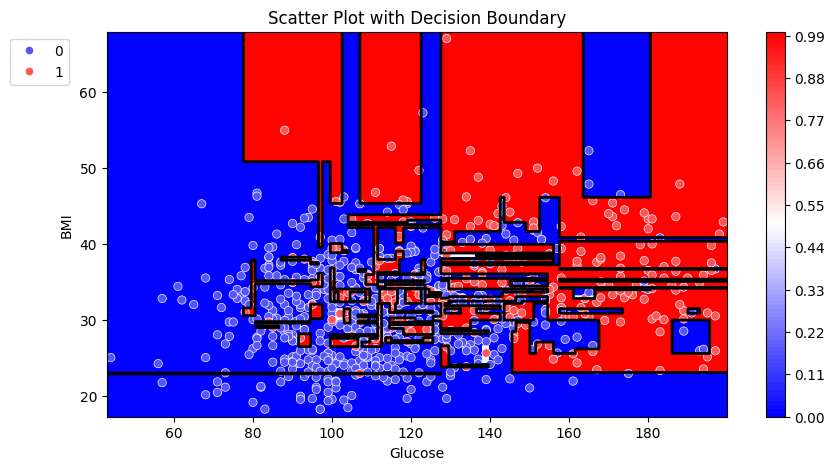

In [35]:
# теперь посмотрим на разделяющую поверхность
plot_probabilities_2d(X, y, dt_clf_bad)

Перед нами типичная картина ПЕРЕОБУЧЕНИЯ дерева решений. Дерево решений разделило пространство на огромное количество отдельных частей, чтобы обозначить все точки из обучающего набора данных правильным классом (уменьшить энтропию до нуля).

Конечно же, такая модель не имеет никакой обобщающей способности и никому не нужна.

**Всегда используйте регуляризацию деревьев — ограничивайте их максимальную глубину (max_depth) и минимальное число объектов в листе (min_samples_leaf)**

In [36]:
# теперь обучим дерево на всех признаках
X = diabetes.drop('Outcome', axis=1)
y = diabetes['Outcome']

In [37]:
dt_clf_full = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=6,
    random_state=42
)
dt_clf_full.fit(X, y)
y_pred = dt_clf_full.predict(X)
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89       493
           1       0.84      0.69      0.76       264

    accuracy                           0.85       757
   macro avg       0.84      0.81      0.82       757
weighted avg       0.84      0.85      0.84       757



Метрики значительно улучшились по сравнению с обучением на двух признаках.

Дерево решений позволяет определить *важность признаков*

In [38]:
# важность признаков можно посмотреть, обратившись к атрибуту
print(dt_clf_full.feature_importances_)

[0.02675774 0.36675873 0.03368236 0.04553664 0.24588118 0.14137465
 0.14000868]


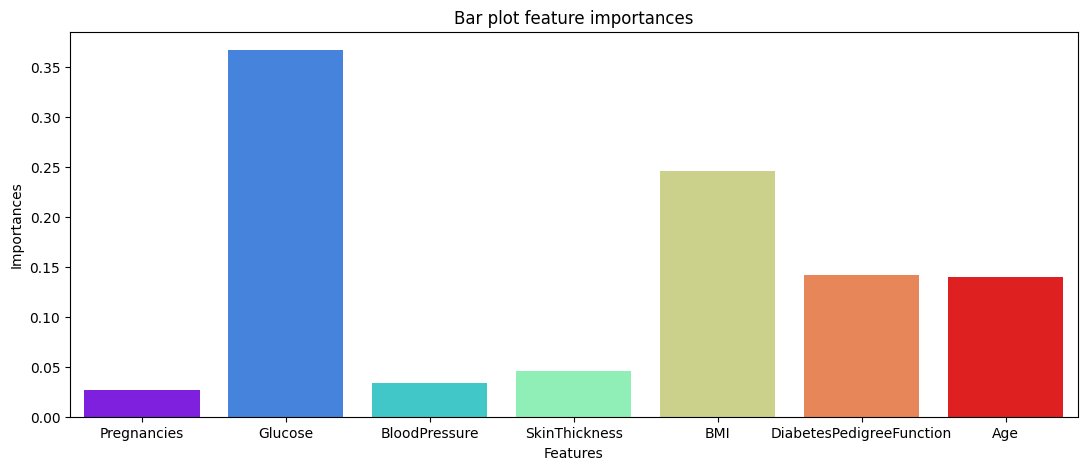

In [39]:
# для удобства и наглядности
fig, ax = plt.subplots(figsize=(13, 5)) #фигура + координатная плоскость
feature = X.columns #признаки
cmap = plt.cm.rainbow
colors = cmap(np.linspace(0, 1, len(feature)))
sns.barplot(x=feature, y=dt_clf_full.feature_importances_, ax=ax, palette=colors);
#Добавляем подпись графику, осям абсцисс и ординат
ax.set_title('Bar plot feature importances')
ax.set_xlabel('Features')
ax.set_ylabel('Importances');

Не стоит приравнивать значимость к корреляции. Корреляция — это коэффициент линейной зависимости, а значимость может отражать и нелинейные связи (в зависимости от сложности дерева).

In [40]:
dt_clf_new = tree.DecisionTreeClassifier(
    criterion='gini',
    max_depth=6,
    random_state=42
)
dt_clf_new.fit(X, y)
y_pred = dt_clf_new.predict(X)
print(metrics.f1_score(y, y_pred))

0.7820773930753564


**Плюсы дерева решений:**
- не требует нормализации/стандартизации данных;
- наличие пропусков не оказывает существенного влияния на построение дерева;
- модель интуитивно понятна и легко объяснима;
- вдобавок получаем значимость признаков. Однако коэффициенты значимости целиком и полностью зависят от сложности дерева.

**Минусы дерева решений:**
- в силу дискретной топологической структуры дерево не дифференцируется по параметрам: стандартные алгоритмы поиска параметров, такие как градиентный спуск, не работают - приходится использовать полный перебор;
- долго обучается, требует затрат больших вычислительных мощностей;
- очень сильная склонность к переобучению - необходим подбор внешних параметров: max_depth, min_sample_leaf и другие;
- небольшое изменение в данных может заметно повлиять на структуру дерева;
- при работе с непрерывными числовыми признаками дерево делит их на категории и теряет информацию. Лучше всего дерево работает, если перевести числовые признаки в категориальные

##  Введение в ансамбли: бэггинг. Случайный лес

Ансамблевые модели или просто ансамбли (ensembles) — это метод машинного обучения, где несколько простых моделей (часто называемых «слабыми учениками») обучаются для решения одной и той же задачи и объединяются для получения лучших результатов.

Необходимость использования ансамблей может возникнуть тогда, когда вы уже нашли хорошую модель и никак больше не можете повысить её качество. В этом случае можно перейти к более продвинутому методу: использовать не одну модель (пусть и очень хорошую), а ансамбли моделей.

**Существует три проверенных способа построения ансамблей:**
1. Бэггинг — параллельно обучаем множество одинаковых моделей, а для предсказания берём среднее по предсказаниям каждой из моделей.
2. Бустинг — последовательно обучаем множество одинаковых моделей, где каждая новая модель концентрируется на тех примерах, где предыдущая допустила ошибку.
3. Стекинг — параллельно обучаем множество разных моделей, отправляем их результаты в финальную модель, и уже она принимает решение.


### Бэггинг

В основе алгоритма лежит статистический метод, который называется бутстрэпом (bootstrap). Идея бутстрэпа заключается в генерации k выборок размера n (бутстрэп-выборок) из исходного набора данных размера m путём случайного выбора элементов с повторениями в каждом из наблюдений.  Обратите внимание, что наблюдения в выборках могут повторяться.

Cредняя ошибка ансамбля, построенного по принципу бэггинга, не выше, чем средняя ошибка базовой модели, но при этом шанс переобучения алгоритма значительно ниже.

Главное преимущество бэггинга — это уменьшение разброса базовой модели за счёт параллельного построения множества моделей на различных обучающих наборах данных. Тем самым уменьшается риск переобучения.

### Случайный лес

Случайный лес (Random Forest) — это самая распространённая реализация бэггинга, основанная на использовании в качестве базовой модели дерева решений. 

Метод случайных подпространств случайным образом выбирает из всех доступных признаков L. Это обеспечивает независимость деревьев друг от друга и уменьшает шанс того, что деревья получатся одинаковыми.

In [41]:
from sklearn import ensemble
X = diabetes[['Glucose', 'BMI']]
y = diabetes['Outcome']

In [42]:
rf_clf_2d = ensemble.RandomForestClassifier(
    n_estimators=500, # число деревьев
    criterion='entropy',
    max_depth=3,
    max_features='sqrt', # число признаков из метода случайных подпространств 
    random_state=42
)

rf_clf_2d.fit(X, y)
y_pred = rf_clf_2d.predict(X)
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.88      0.84       493
           1       0.73      0.57      0.64       264

    accuracy                           0.78       757
   macro avg       0.76      0.73      0.74       757
weighted avg       0.77      0.78      0.77       757



К сожалению, визуализировать то, как случайный лес принимает решение, как мы это делали с одним деревом решений, у нас не получится, так как в таком случае пришлось бы визуализировать 500 деревьев. Однако мы можем построить разделяющую поверхность нашего леса, воспользовавшись нашей функцией.

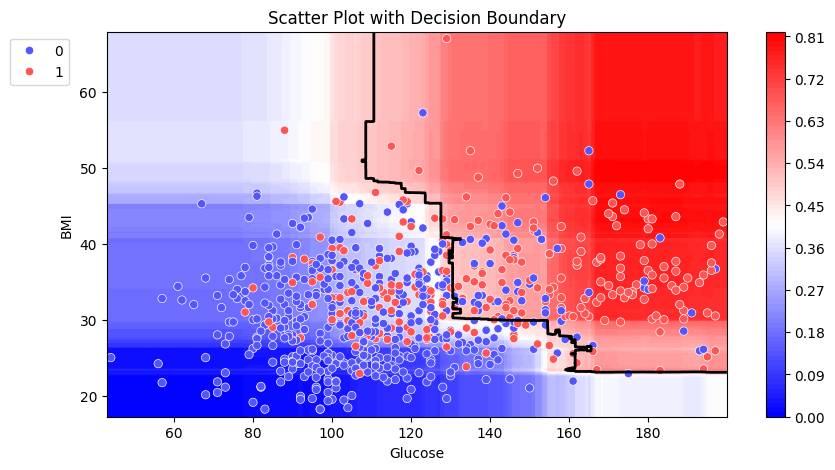

In [43]:
plot_probabilities_2d(X, y, rf_clf_2d)

In [45]:
#Создаём матрицу признаков X и столбец с ответами y
X = diabetes.drop('Outcome', axis=1)
y = diabetes['Outcome']
 
 
#Создаём объект класса RandomForestClassifier
rf_clf_full = ensemble.RandomForestClassifier(
    n_estimators=300, #число деревьев
    criterion='entropy', #критерий эффективности
    max_depth=6, #максимальная глубина дерева
    max_features='sqrt', #число признаков из метода случайных подпространств
    random_state=42 #генератор случайных чисел
)
#Обучаем модель 
rf_clf_full.fit(X, y)
 
#Делаем предсказание класса
y_pred = rf_clf_full.predict(X)
#Выводим отчёт о метриках
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       493
           1       0.85      0.77      0.80       264

    accuracy                           0.87       757
   macro avg       0.86      0.85      0.85       757
weighted avg       0.87      0.87      0.87       757



К сожалению, визуализировать построенный лес в виде дерева, как и построить разделяющую поверхность леса, не получится. Это утверждение относится ко всем ансамблевым алгоритмам. Человеку сложно понять, по какому принципу ансамбль принимает решение. Это один из основных их недостатков. 

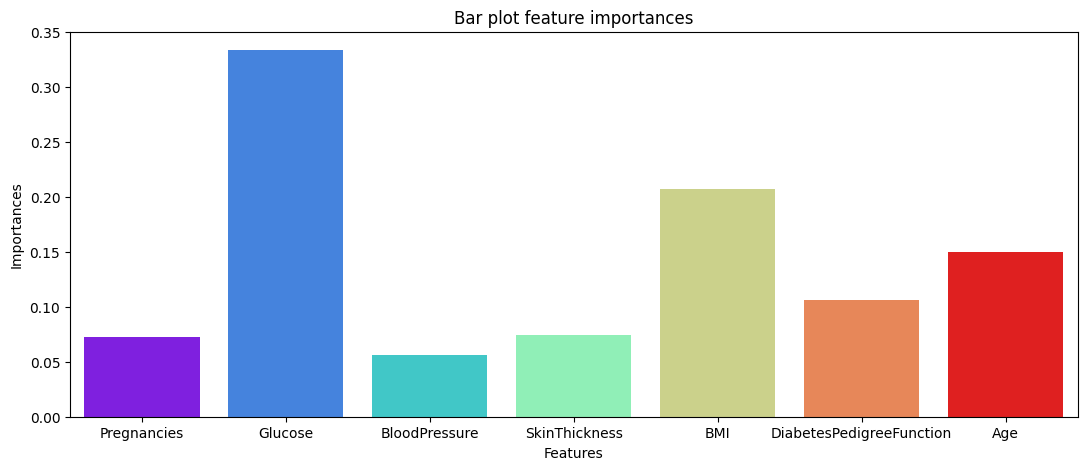

In [46]:
# тут тоже есть штука с важностью признаков
fig, ax = plt.subplots(figsize=(13, 5)) #фигура + координатная плоскость
feature = X.columns #признаки
feature_importances = rf_clf_full.feature_importances_ #важность признаков
#Строим столбчатую диаграмму
cmap = plt.cm.rainbow
colors = cmap(np.linspace(0, 1, len(feature)))
sns.barplot(x=feature, y=feature_importances, ax=ax, palette=colors);
#Добавляем подпись графику, осям абсцисс и ординат
ax.set_title('Bar plot feature importances')
ax.set_xlabel('Features')
ax.set_ylabel('Importances');

In [47]:
wine = pd.read_csv('/Users/olgazdanova/Downloads/winequality-red.csv', sep=';')
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [48]:
wine['quality'] = wine['quality'].apply(lambda x: 1 if x>= 6 else 0)
X = wine.drop('quality', axis=1)
y = wine['quality']

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
rf_clf_new = ensemble.RandomForestClassifier(
    n_estimators=500, 
    max_depth=8, 
    max_features='sqrt', 
    criterion='gini', 
    min_samples_leaf=10,
    random_state=42
)

rf_clf_new.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, min_samples_leaf=10, n_estimators=500,
                       random_state=42)

In [56]:
y_pred_train = rf_clf_new.predict(X_train)
y_pred_test = rf_clf_new.predict(X_test)
print('Train Accuracy: {:.2f}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Test Accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_pred_test)))

Train Accuracy: 0.85
Test Accuracy: 0.75
